In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import shuffle

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [3]:
# Changes the font parameters for the charts
params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

In [4]:
params = {}

In [5]:
## Change to the 'Datasets directory'
initial_dir = os.getcwd()
data_folder = os.path.join(os.getcwd(), 'Datasets')
data_path = os.path.join(data_folder, "data")

In [6]:
## Import the train and test dataframes. Drop the 'dateRep' column as it is not need for the prediciton.
train_X = pd.read_csv(os.path.join(data_path, "train", 'train_x.csv'), index_col=0).drop(columns=['dateRep']).sample(frac=1, random_state=1)
train_y = pd.read_csv(os.path.join(data_path, "train", 'train_y.csv'), index_col=0).drop(columns=['dateRep']).sample(frac=1, random_state=1)
## '.sample' randomises the dataframe as the validation test below will take the bottom 20% of the data
## 'frac=1' means it will use all the data and 'random_state=1' keeps the resample consistent between df's
test_x = pd.read_csv(os.path.join(data_path, "test", 'test_x.csv'), index_col=0).drop(columns=['dateRep']).sample(frac=1, random_state=1)
test_y = pd.read_csv(os.path.join(data_path, "test", 'test_y.csv'), index_col=0).drop(columns=['dateRep']).sample(frac=1, random_state=1)

In [7]:
## Initialise Scalars so that data is normalised to 1.
sc_x = StandardScaler()
sc_y = StandardScaler()
## Normalise the data using the scalar.
X_train = sc_x.fit_transform(train_X)
X_test = sc_x.transform(test_x)

y_train = sc_y.fit_transform(train_y)
y_test = sc_y.transform(test_y)

In [8]:
## Calculate the number of input 'test' columns.
input_neuron = len(test_x.columns)
input_neuron

22

In [9]:
## Setup the model for training, parameters here can and should be adjusted to create the best model.
classifier = Sequential()
classifier.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu', input_dim = input_neuron))
classifier.add(Dense(output_dim = 6, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'linear'))

classifier.compile(optimizer = 'SGD', loss = 'mean_squared_error', metrics = ["mae"])
## '.fit' starts the training. 30 seconds to 2 minutes to run.
classifier.fit(X_train, y_train, batch_size = 64, nb_epoch = 1000, validation_split= 0.2)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=22, units=18, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=6, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1, kernel_initializer="uniform")`
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':



Train on 1699 samples, validate on 425 samples
Epoch 1/1000
1699/1699 [==============================] - 0s 177us/step - loss: 0.9887 - mae: 0.4376 - val_loss: 1.0483 - val_mae: 0.4924
Epoch 2/1000
1699/1699 [==============================] - 0s 19us/step - loss: 0.9883 - mae: 0.4333 - val_loss: 1.0487 - val_mae: 0.4903
Epoch 3/1000
1699/1699 [==============================] - 0s 17us/step - loss: 0.9884 - mae: 0.4328 - val_loss: 1.0488 - val_mae: 0.4896
Epoch 4/1000
1699/1699 [==============================] - 0s 17us/step - loss: 0.9881 - mae: 0.4297 - val_loss: 1.0481 - val_mae: 0.4930
Epoch 5/1000
1699/1699 [==============================] - 0s 17us/step - loss: 0.9881 - mae: 0.4350 - val_loss: 1.0486 - val_mae: 0.4906
Epoch 6/1000
1699/1699 [==============================] - 0s 17us/step - loss: 0.9881 - mae: 0.4357 - val_loss: 1.0493 - val_mae: 0.4871
Epoch 7/1000
1699/1699 [==============================] - 0s 16us/step - loss: 0.9884 - mae: 0.4295 - val_loss: 1.0489 - val_mae:

In [10]:
model_path = os.path.join(data_folder, "model")
# Check if the relevant folders exist and create them if not
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
# Export the model for future use to that you don't need to spend time training the model again
pickle.dump(classifier, open(os.path.join(model_path, "ReinNN.pkl"), "wb"))

In [11]:
"""model_path = os.path.join(data_folder, "model")
# Import the exported model in future runs using the greyed out line below (remove the hastag)
model = pickle.load(open(os.path.join(model_path, "ReinNN.pkl"), "rb"))"""

'model_path = os.path.join(data_folder, "model")\n# Import the exported model in future runs using the greyed out line below (remove the hastag)\nmodel = pickle.load(open(os.path.join(model_path, "ReinNN.pkl"), "rb"))'

In [12]:
# Calculate the predicted deaths according to the neural net model
test_x["deaths_pred"] = sc_y.inverse_transform(classifier.predict(X_test))
#df1 = pd.concat([test_x, train_X], axis=1)
df= train_X.merge(train_y,left_index=True, right_index=True)
# We merge the test dataframes together
df1 = test_x.merge(test_y, left_index=True, right_index=True)
# We append the test data to the train data
df = df.append(df1)

In [13]:
## Calculate the mean absolute error and R2 scores for the predicted vs real data.
print(f"DL MAE score: {np.round(mean_absolute_error(df1.deaths, df1.deaths_pred))}")
print(f"DL R2 score: {np.round(r2_score(df1.deaths, df1.deaths_pred), 4)}")

DL MAE score: 127.0
DL R2 score: 0.7337


In [14]:
# Again read in the 'covid19_df' as df_global
df_global = pd.read_csv(os.path.join(data_folder, "Data_Export", "covid19_df.csv"), index_col=0)
# Merge in the 'deaths_pred' prediction column to compare to the real data
df_global = df_global.merge(df["deaths_pred"], left_index=True, right_index=True, how='left')

In [15]:
# Compute the prediction error
df_global['deaths_pred_error'] = df_global['deaths'] - df_global['deaths_pred']
# Compute the cumulative error for each country individually
df_global['cumulative_error'] = df_global.groupby('countriesAndTerritories')['deaths_pred_error'].cumsum()

In [16]:
# Recreate the 'top_count' list to create the graphs below
top_count = list(df_global.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20].keys())

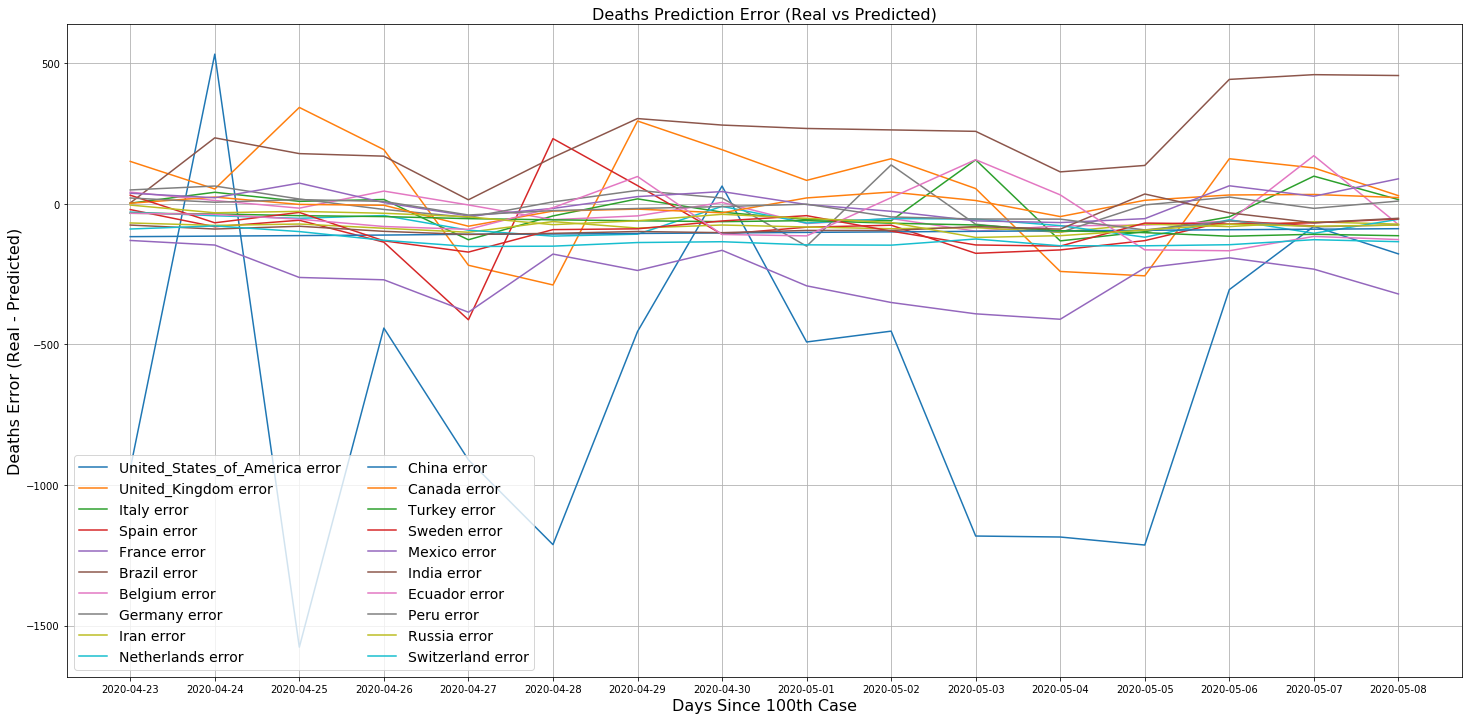

In [17]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['deaths_pred_error'], label=f"{country} error")
plt.title('Deaths Prediction Error (Real vs Predicted)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Deaths Error (Real - Predicted)')
plt.grid()
plt.legend(ncol=2, loc=3)

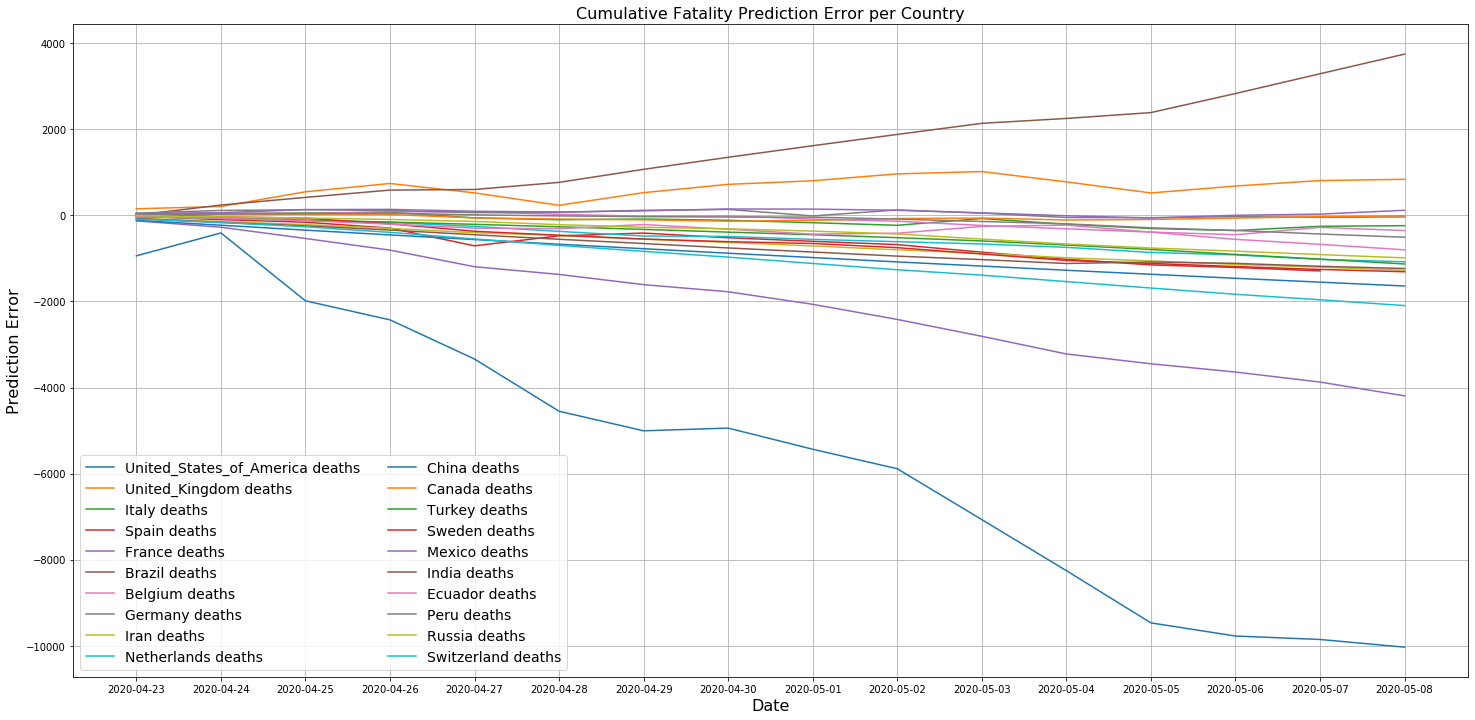

In [18]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(df_global[df_global["countriesAndTerritories"] == country]["dateRep"],
             df_global[df_global["countriesAndTerritories"] == country]['cumulative_error'], label=f"{country} deaths")
plt.title('Cumulative Fatality Prediction Error per Country')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.grid()
plt.legend(ncol=2)
#plt.savefig('cumulative_error_20_nn_countries_dpi300.jpeg', dpi=300)

In [19]:
## Check for the directory and output the df_global dataframe.
if os.path.exists(os.path.join(data_folder, "model_predictions")) is False:
    os.mkdir(os.path.join(data_folder, "model_predictions"))
df_global.to_csv(os.path.join(data_folder, "model_predictions", "Rein_nn_predictions.csv"))

In [20]:
#plt.style.use("ggplot")

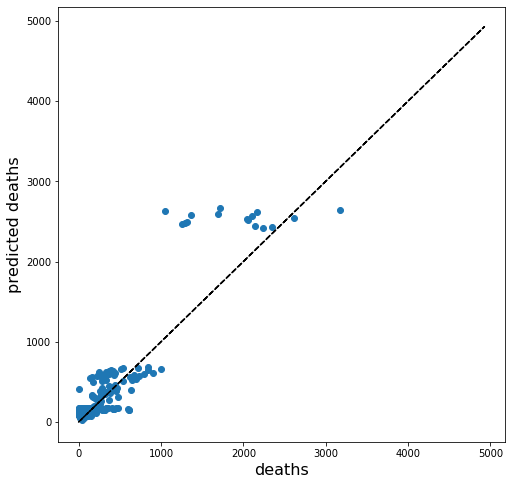

In [21]:
## Plot deaths vs predicted.
plt.figure(figsize=(8, 8))
plt.scatter(df.deaths, df.deaths_pred)
plt.plot(df.deaths, df.deaths, color="black", linestyle="--")
plt.xlabel("deaths")
plt.ylabel("predicted deaths")
plt.show()